# Klassifizierung von Wetterdaten

In [140]:
import numpy as np
import pandas as pd
import seaborn as sns
import datetime as dt
from matplotlib import pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn import datasets, linear_model, metrics
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve

raw = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

## 1) Data preperation
### Verschaffen Sie sich einen Überblick (Wertebereich einzelner Features, mögliche Korrelationen, Ausreißer, fehlende Werte)

In [124]:
raw.head(3)

,index,Datum,Temperatur,Luftfeuchtigkeit,CO2,Wassergehalt,Anwesenheit
0,1,2017-01-25 17:51:00,23.18,27.2720,721.25,0.004793,1
1,2,2017-01-25 17:51:59,23.15,27.2675,714.00,0.004783,1
2,3,2017-01-25 17:53:00,23.15,27.2450,713.50,0.004779,1


In [125]:
raw.describe()

,index,Temperatur,Luftfeuchtigkeit,CO2,Wassergehalt,Anwesenheit
count,14241.000000,14236.000000,14234.000000,14237.000000,14241.000000,14241.000000
mean,3017.740117,21.005526,25.941076,628.058885,0.003995,0.256513
std,2235.616814,1.148923,4.581677,279.339892,0.000754,0.436724
min,1.000000,19.000000,16.745000,412.750000,0.002674,0.000000
25%,1234.000000,20.290000,22.675000,446.000000,0.003441,0.000000
50%,2420.000000,20.835000,25.726250,512.000000,0.003918,0.000000
75%,4583.000000,21.700000,28.650000,694.750000,0.004524,1.000000
max,8143.000000,24.408333,39.117500,2028.500000,0.006476,1.000000


In [126]:
raw.isna().sum()

index               0
Datum               0
Temperatur          5
Luftfeuchtigkeit    7
CO2                 4
Wassergehalt        0
Anwesenheit         0
dtype: int64

In [127]:
# Von Torben übernommeses Cleaning der fehlenden Werte
lead = raw.loc[:,:'Datum']
tail = raw.loc[:,'Temperatur':]
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit(tail)
SimpleImputer()
tail = pd.DataFrame(imp.transform(tail), columns = tail.columns)
tail = tail.iloc[:14241,:]
raw = pd.concat([lead, tail],axis=1)
raw.drop(['index'], inplace=True, axis=1)
raw

,Datum,Temperatur,Luftfeuchtigkeit,CO2,Wassergehalt,Anwesenheit
0,2017-01-25 17:51:00,23.18,27.2720,721.25,0.004793,1.0
1,2017-01-25 17:51:59,23.15,27.2675,714.00,0.004783,1.0
2,2017-01-25 17:53:00,23.15,27.2450,713.50,0.004779,1.0
3,2017-01-25 17:54:00,23.15,27.2000,708.25,0.004772,1.0
4,2017-01-25 17:55:00,23.10,27.2000,704.50,0.004757,1.0
...,...,...,...,...,...,...
14236,2017-02-03 23:55:59,20.10,33.5900,505.00,0.004890,0.0
14237,2017-02-03 23:57:00,20.00,33.5000,504.50,0.004847,0.0
14238,2017-02-03 23:57:59,20.00,33.5000,500.50,0.004847,0.0
14239,2017-02-03 23:58:59,20.00,33.5000,502.00,0.004847,0.0


In [128]:
corr = raw.corr()
corr.style.background_gradient(cmap='coolwarm')
# Interessante Korrelation zwischen CO2 & Anwesenheit, Temperatur & Anwesenheit, Temperatur & CO2

,Temperatur,Luftfeuchtigkeit,CO2,Wassergehalt,Anwesenheit
Temperatur,1.000000,-0.042913,0.545736,0.345093,0.548405
Luftfeuchtigkeit,-0.042913,1.000000,0.410889,0.920885,0.172835
CO2,0.545736,0.410889,1.000000,0.614993,0.660436
Wassergehalt,0.345093,0.920885,0.614993,1.000000,0.384524
Anwesenheit,0.548405,0.172835,0.660436,0.384524,1.000000


<AxesSubplot:xlabel='Wassergehalt', ylabel='Anwesenheit'>

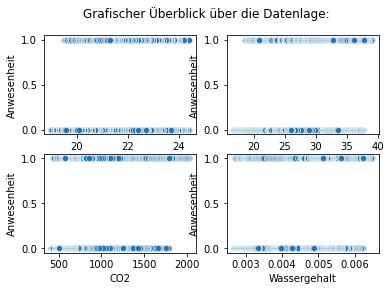

In [129]:
fig, axes = plt.subplots(2, 2)
fig.suptitle('Grafischer Überblick über die Datenlage:')
sns.scatterplot(data=raw, x='Temperatur', y='Anwesenheit', ax=axes[0,0])
sns.scatterplot(data=raw, x='Luftfeuchtigkeit', y='Anwesenheit', ax=axes[0,1])
sns.scatterplot(data=raw, x='CO2', y='Anwesenheit', ax=axes[1,0])
sns.scatterplot(data=raw, x='Wassergehalt', y='Anwesenheit', ax=axes[1,1])

In [130]:
raw.dtypes

Datum                object
Temperatur          float64
Luftfeuchtigkeit    float64
CO2                 float64
Wassergehalt        float64
Anwesenheit         float64
dtype: object

In [131]:
# Problem für spätere logistische Regression: datetime oder object erzeugt " TypeError: float() argument must be a string or a number, not 'Timestamp' "
# Lösung: https://stackoverflow.com/questions/16453644/regression-with-date-variable-using-scikit-learn
raw['Datum'] = raw.Datum.astype('datetime64[ns]')

raw['Jahr'] = raw['Datum'].dt.year
raw['Monat'] = raw['Datum'].dt.month
raw['Tag'] = raw['Datum'].dt.day
raw['Stunde'] = raw['Datum'].dt.hour
raw['Minute'] = raw['Datum'].dt.minute
raw['Sekunde'] = raw['Datum'].dt.second
raw['Wochentag'] = raw['Datum'].dt.strftime("%A")

raw.drop(['Datum'], inplace=True, axis=1)

# One Hot Encoding, um kein Object type in den Daten zu haben
Wochentag = pd.get_dummies(raw[['Wochentag']], columns=['Wochentag'])
raw = pd.concat([raw, Wochentag], axis=1) 
raw.drop(['Wochentag'], inplace=True, axis=1)

df = raw

## 2) Logical Regression

In [134]:
X = df.drop("Anwesenheit",axis=1).values
y = df["Anwesenheit"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((11392, 17), (2849, 17), (11392,), (2849,))

In [135]:
logreg = LogisticRegressionCV(cv=10, random_state=42, max_iter=4000).fit(X, y) # Kreuzvalidierung

y_pred = logreg.predict(X_test)
y_proba = logreg.predict_log_proba(X_test)

In [136]:
confusion_matrix(y_test, y_pred)

array([[2010,  106],
       [ 195,  538]], dtype=int64)

In [137]:
kreuztabelle = pd.crosstab(index=y_pred, columns=y_test, rownames=["predicted"], colnames=["actual"])
TP = kreuztabelle.values[1,1]
FP = kreuztabelle.values[1,0]
FN = kreuztabelle.values[0,1]
TN = kreuztabelle.values[0,0]
kreuztabelle.sort_index(axis=0, ascending=False).sort_index(axis=1, ascending=False)

actual,1.0,0.0
predicted,,
1.0,538,106
0.0,195,2010


In [138]:
precision = TP/(TP+FP)
TPR = TP/(TP+FN) # Recall
accuracy = (TP+TN)/(TP+TN+FN+TN)
F1 = 2*(precision*TPR/(precision+TPR))
FPR = FP/(FP+TN)

# Precision: Welcher Anteil der als 1 klassifizierten Daten ist auch mit 1 gelabelt?
print(f"Precision: {precision}")
# Accuracy: Anteil der korrekten (0 oder 1 Vorhersagen) an allen Vorhersagen
print(f"Accuracy Score: {accuracy}")
# F1:was macht ein gutes Modell aus? Sowohl eine hohe Trefferquote haben als auch präzise
print(f"F1: {F1}")
# Recall: Welchen Anteil der mit 1 gelabelten Daten findet der Klassifikator?
print(f"Recall (TPR): {TPR}")

print(f"FPR: {FPR}")

Precision: 0.8354037267080745
Accuracy Score: 0.5360824742268041
F1: 0.7814088598402325
Recall (TPR): 0.7339699863574352
FPR: 0.0500945179584121


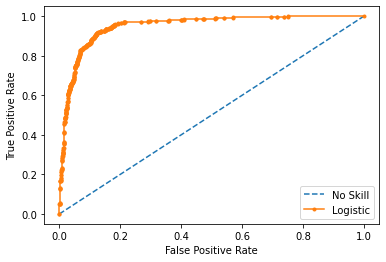

In [142]:
yhat = y_proba[:, 1]
# ROC Kurve berechnen
fpr, tpr, thresholds = roc_curve(y_test, yhat)
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Logistic')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

plt.show()